In [2]:
# ! pip install asyncpg

In [3]:
%run credentials.ipynb

In [4]:
import asyncio
import asyncpg

import pandas as pd
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
conn = await asyncpg.connect(
    user=user, password=password,
    database=dbname,
    host=host, port=port,
    ssl='require'
)
# await conn.close()

In [7]:
async def query_res_to_df(query):
    data = await conn.fetch(query)

    return pd.DataFrame(data, columns=list(data[0].keys()))

In [8]:
orders_sample = await query_res_to_df('select * from orders limit 2')
orders_sample

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id
0,3158715,61138,290.0,290.0,2543,0.0,89906,35,shipped,2018-01-05 10:50:00,2018-01-05 00:07:04,448086,2,75258
1,3182881,73307,190.0,190.0,6076,0.0,30275,52,shipped,2018-01-06 15:33:54,2018-01-05 02:04:42,450946,10,75860


In [9]:
delivery_windows_sample = await query_res_to_df('select * from delivery_windows limit 5')
delivery_windows_sample

,store_id,id,starts_at,ends_at,time_zone
0,2,75258,2018-01-05 08:00:00,2018-01-05 10:00:00,Europe/Moscow
1,10,75860,2018-01-06 15:00:00,2018-01-06 17:00:00,Europe/Moscow
2,14,78635,2018-01-11 06:00:00,2018-01-11 08:00:00,Europe/Moscow
3,21,75403,2018-01-05 09:00:00,2018-01-05 11:00:00,Europe/Moscow
4,3,75825,2018-01-06 16:00:00,2018-01-06 18:00:00,Europe/Moscow


In [10]:
stores_sample = await query_res_to_df('select * from stores limit 5')
stores_sample

,id,city,retailer_id
0,1,1,1
1,2,1,1
2,3,1,1
3,8,1,1
4,9,1,1


In [11]:
addresses_sample = await query_res_to_df('select * from addresses limit 5')
addresses_sample

,lat,lon,id,elevator,floor
0,55.872131,37.640294,6017,passenger,4
1,55.834058,37.323884,7047,None,-
2,55.802137,37.846993,8531,passenger,21
3,55.793141,37.526937,10417,passenger,2
4,55.818450,37.519013,10472,None,-


In [12]:
cancellations_sample = await query_res_to_df('select * from cancellations limit 5')
cancellations_sample

,order_id,item_id,state
0,3182881,5331852,canceled
1,3182881,5351271,canceled
2,3182881,5351087,canceled
3,3182881,5351090,canceled
4,3146329,5356620,canceled


In [13]:
replacements_sample = await query_res_to_df('select * from replacements limit 5')
replacements_sample

,order_id,item_id,state
0,3190332,5332717,replaced
1,3190332,5332761,replaced
2,3097213,5332862,replaced
3,3097213,5332917,replaced
4,3188867,5440591,replaced


In [14]:
def get_unique_query(table):
    return f'''
        select *
        from (
            select
                *,
                row_number() over (partition by id) as row_number
            from {table}
        ) as t
        where row_number = 1
    '''

In [15]:
columns_query = []

for (table, columns) in [
    ('orders', orders_sample.columns),
    ('stores', set(stores_sample.columns) - {'id'}),
    ('dw', set(delivery_windows_sample.columns) - {'id', 'time_zone', 'store_id', 'delivery_window_id'}),
    ('addresses', set(addresses_sample.columns) - {'id', 'elevator', 'floor', 'ship_address_id'}),
    ('canceled', {'canceled_count'}),
    ('replaced', {'replaced_count'}),
]:
    for column in columns:
        columns_query.append(f'{table}.{column} as {column}')
columns_query = ','.join(columns_query)

In [16]:
delivery_windows = 'delivery_windows'

# data_all = await query_res_to_df(f'''
data = await query_res_to_df(f'''
    select *
    from (
        select {columns_query}

        from orders

        left join ({get_unique_query(delivery_windows)}) as dw
        on orders.delivery_window_id = dw.id

        left join stores on orders.store_id = stores.id

        left join addresses on orders.ship_address_id = addresses.id
        
        left join (
            select order_id, count(1) as canceled_count
            from cancellations
            group by order_id
        ) as canceled on orders.id = canceled.order_id
        
        left join (
            select order_id, count(1) as replaced_count
            from replacements
            group by order_id
        ) as replaced on orders.id = replaced.order_id
    ) as t
''')

# data = data_all.sample(10000)

In [17]:
data.columns

Index(['id', 'user_id', 'total_cost', 'cost', 'item_total', 'promo_total',
       'total_weight', 'total_quantity', 'state', 'shipped_at', 'created_at',
       'ship_address_id', 'store_id', 'delivery_window_id', 'city',
       'retailer_id', 'starts_at', 'ends_at', 'lat', 'lon', 'canceled_count',
       'replaced_count'],
      dtype='object')

In [18]:
assert len(data.columns) == len(set(data.columns))

In [19]:
data['canceled_count'] = data['canceled_count'].fillna(0)

In [20]:
data['replaced_count'] = data['replaced_count'].fillna(0)

In [21]:
# data['canceled_frac'] = data['canceled_count'] / data['total_quantity']

In [22]:
# data['replaced_frac'] = data['replaced_count'] / data['total_quantity']

In [23]:
data['is_damaged'] = (data['canceled_count'] > 0) | (data['replaced_count'] > 0)

In [24]:
data['delivery_time'] = data['shipped_at'] - data['created_at']

In [25]:
data['estimated_delivery_time'] = data['ends_at'] - data['created_at']

In [26]:
data['month'] = data['created_at'].dt.strftime('%Y-%m')

In [27]:
data['day_of_week'] = data['created_at'].dt.dayofweek

In [28]:
data['day_of_week_shipped'] = data['shipped_at'].dt.dayofweek

## Разделим средний чек покупки на дешевый, средний и дорогой

(6438.0, 3873.0, 2301.0)

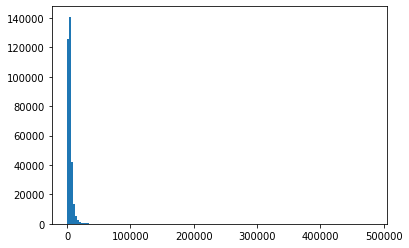

In [29]:
plt.hist(data['item_total'], bins=150);

item_total_08 = data['item_total'].quantile(0.8)
item_total_05 = data['item_total'].quantile(0.5)
item_total_02 = data['item_total'].quantile(0.2)
item_total_08, item_total_05, item_total_02

In [30]:
cheap, middle = item_total_02, item_total_08

In [31]:
data['item_total_class'] = 'cheap'
data.loc[(data['item_total'] > cheap), 'item_total_class'] = 'middle'
data.loc[(data['item_total'] > middle), 'item_total_class'] = 'expensive'

## Доставлен ли товар вовремя?

In [32]:
data['in_time'] = 'in_time'

In [33]:
data.loc[(data['starts_at'] > data['shipped_at']), 'in_time'] = 'earlier'
data.loc[(data['ends_at'] < data['shipped_at']), 'in_time'] = 'later'

## Насколько раньше/позже привезли товар, чем ожидалось (в часах)

In [34]:
data['delta_t'] = 0
data.loc[(data['in_time'] == 'earlier'), 'delta_t'] = (data[data['in_time'] == 'earlier']['shipped_at'] - data[data['in_time'] == 'earlier']['starts_at']).dt.total_seconds() / 3600
data.loc[(data['in_time'] == 'later'), 'delta_t'] = (data[data['in_time'] == 'later']['shipped_at'] - data[data['in_time'] == 'later']['ends_at']).dt.total_seconds() / 3600



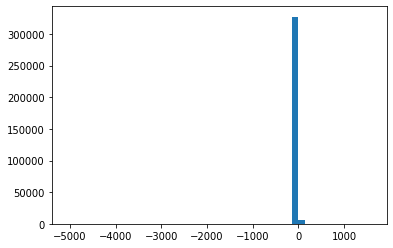

In [35]:
plt.hist(data['delta_t'], bins=50);

## Сколько раз каждый пользователь применил промокод?

In [36]:
data_promo = data[['user_id', 'cost', 'total_cost']][data['total_cost'] != data['cost']].groupby('user_id').count()

data_promo['promo_count'] = data_promo['cost']
data_promo = data_promo.drop(['cost', 'total_cost'], axis=1).reset_index()

data = pd.merge(data, data_promo, how='left', on='user_id')
data['promo_count'] = data['promo_count'].fillna(0)

## Количество заказов от каждого пользователя

In [37]:
data_order = data[['user_id', 'cost']].groupby('user_id').count()

data_order['order_count'] = data_order['cost']
data_order = data_order.drop(['cost'], axis=1).reset_index()
data = pd.merge(data, data_order, how='left', on='user_id')

## Возвращаются ли клиенты после первого заказа?

In [38]:
data['old_client'] = data['order_count'] > 1

## Средний чек клиента

In [39]:
data_item_total = data[['user_id', 'item_total']].groupby('user_id').sum()
data_item_total['item_total_avg'] = data_item_total['item_total']
data_item_total = data_item_total.drop(['item_total'], axis=1).reset_index()
data = pd.merge(data, data_item_total, how='left', on='user_id')
data['item_total_avg'] = data['item_total_avg'] / data['order_count']

## Разделение клиентов на классы

(6254.100000000006, 4090.0, 2704.1428571428573)

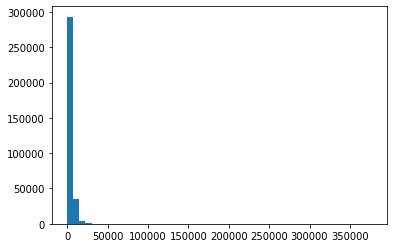

In [40]:
plt.hist(data['item_total_avg'], bins=50);

item_total_avg_08 = data['item_total_avg'].quantile(0.8)
item_total_avg_05 = data['item_total_avg'].quantile(0.5)
item_total_avg_02 = data['item_total_avg'].quantile(0.2)
item_total_avg_08, item_total_avg_05, item_total_avg_02

In [41]:
middle, low = item_total_avg_08, item_total_avg_02

In [42]:
data['user_class'] = 'low'
data.loc[(data['item_total_avg'] > low), 'user_class'] = 'middle'
data.loc[(data['item_total_avg'] > middle), 'user_class'] = 'high'

## Разбить количество товаров по классам

(111.0, 31.0, 10.0)

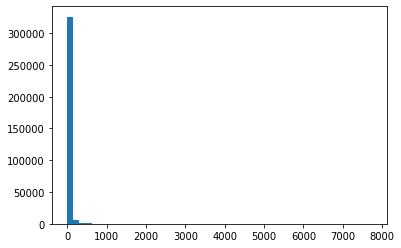

In [43]:
plt.hist(data['total_quantity'], bins=50);

total_quantity_095 = data['total_quantity'].quantile(0.95)
total_quantity_05 = data['total_quantity'].quantile(0.5)
total_quantity_01 = data['total_quantity'].quantile(0.1)
total_quantity_095, total_quantity_05, total_quantity_01

In [44]:
mid, few = 30, 10

In [45]:
data['total_quantity_class'] = 'few'
data.loc[(data['total_quantity'] > few), 'total_quantity_class'] = 'mid'
data.loc[(data['total_quantity'] > middle), 'total_quantity_class'] = 'many'

## Разбить вес заказа по классам

(36700.0, 18180.0, 8090.0)

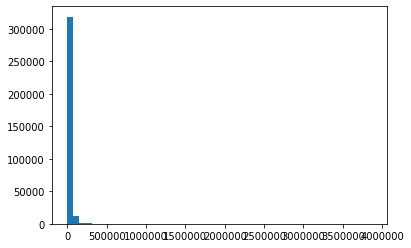

In [46]:
plt.hist(data['total_weight'], bins=50);

total_weight_08 = data['total_weight'].quantile(0.8)
total_weight_05 = data['total_weight'].quantile(0.5)
total_weight_02 = data['total_weight'].quantile(0.2)
total_weight_08, total_weight_05, total_weight_02

In [47]:
middle, light = total_weight_08, total_weight_02

In [48]:
data['total_weight_class'] = 'light'
data.loc[(data['total_weight'] > light), 'total_weight_class'] = 'mid'
data.loc[(data['total_weight'] > middle), 'total_weight_class'] = 'heavy'

## Разбить по городам

In [49]:
data["lat"] = data["lat"].fillna(-50)
data["lon"] = data["lon"].fillna(-50)

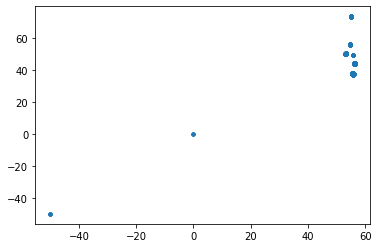

In [50]:
plt.scatter(data["lat"], data["lon"], s=10, alpha=0.4)

In [51]:
from sklearn.cluster import KMeans

In [52]:
X = data[['lat', 'lon']].values

In [53]:
city = KMeans(n_clusters=8, random_state=1).fit_predict(X)
data['city'] = city

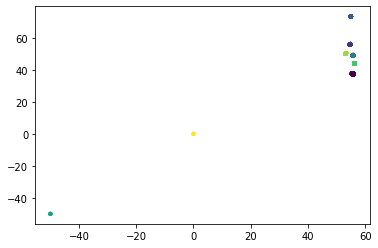

In [54]:
plt.scatter(data["lat"], data["lon"], s=10, alpha=0.4, c=data['city'])

## Перевести timestamp в более удобный формат

In [60]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,334245,4.18827e+06,658829,557,3.63464e+06,4.1346e+06,4.74542e+06,5.5132e+06
user_id,334245,177843,130990,31,84872,146590,243751,682383
total_cost,334245,189.069,175.353,-298,0,199,299,9500
cost,334245,257.827,172.494,0,199,299,299,9500
item_total,334245,4917.52,5526.47,0,2566,3873,5806,480746
promo_total,334245,-66.5232,304.918,-39899.3,0,0,0,0
total_weight,334245,26925.8,41873.1,0,9685,18180,31935,3.864e+06
total_quantity,334245,44.1927,75.0549,0,18,31,50,7728
ship_address_id,334245,1.38898e+06,610806,6017,853173,1.33377e+06,1.89074e+06,2.66970e+06
store_id,334245,23.1895,29.6922,1,8,11,21,120


In [59]:
data['delivery_time'] = data['delivery_time'].dt.total_seconds() / 3600

In [61]:
data['estimated_delivery_time'] = data['estimated_delivery_time'].dt.total_seconds() / 3600

In [ ]:
data.to_csv('data.csv')